In [21]:
import numpy as np

from figures.controls.samples.sim_data.sim_data_tools import *
import pylab as plt
import tensorflow as tf
from model.Sample_MIL import InstanceModels, RaggedModels
from model import DatasetsUtils
from sklearn.model_selection import StratifiedShuffleSplit
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[-1], True)
tf.config.experimental.set_visible_devices(physical_devices[-1], 'GPU')

#Let's create some simulated mutation data where the positive class is defined by having mutations with a specific sequence 5' of the mutation.

In [2]:
def generate_sample(mean_variants=[5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300],
                    control=True, positive_choices=None, negative_instances=False, fixed=['five_p']):
    if negative_instances and len(positive_choices) <= 1:
        raise ValueError
    center = np.random.choice(mean_variants, 1)
    total_count = int(np.random.normal(center, int(np.ceil(center * .2))))
    if total_count < 1:
        total_count *= -1
    if total_count == 0:
        total_count = np.random.choice([2, 3, 4, 5, 6], 1)
    if control:
        if negative_instances:
            positive_count = int(np.ceil(np.random.random() * total_count))
            control_count = total_count - positive_count
        else:
            control_count = total_count
            positive_count = 0
    else:
        positive_counts = [int(np.ceil(np.random.random() / len(positive_choices) * total_count)) for i in positive_choices]
        control_count = total_count - sum(positive_counts)

    control_count = max(control_count, 0)
    positive_variants = []
    positive_instances = []

    control_variants = [generate_variant() for i in range(control_count)]
    if control:
        while True:
            y = False
            for i in control_variants:
                if check_variant(i, positive_choices, to_check=fixed):
                    y = True
                    break
            if y:
                control_variants = [generate_variant() for i in range(control_count)]
            else:
                break

    if control:
        if negative_instances:
            positive_choice = int(np.random.choice(range(len(positive_choices)), 1))
            for i in range(positive_count):
                positive_variant = list(generate_variant())
                if 'five_p' in fixed:
                    positive_variant[0] = positive_choices[positive_choice][0]
                if 'three_p' in fixed:
                    positive_variant[1] = positive_choices[positive_choice][1]
                if 'ref' in fixed:
                    positive_variant[2] = positive_choices[positive_choice][2]
                if 'alt' in fixed:
                    positive_variant[3] = positive_choices[positive_choice][3]
                positive_variants.append(positive_variant)
                positive_instances.append(positive_choice + 1)
        else:
            pass

    else:
        for index, i in enumerate(positive_choices):
            for ii in range(positive_counts[index]):
                positive_variant = list(generate_variant())
                if 'five_p' in fixed:
                    positive_variant[0] = i[0]
                if 'three_p' in fixed:
                    positive_variant[1] = i[1]
                if 'ref' in fixed:
                    positive_variant[2] = i[2]
                if 'alt' in fixed:
                    positive_variant[3] = i[3]
                positive_variants.append(positive_variant)
                positive_instances.append(index + 1)

    return [control_variants + positive_variants, [0] * len(control_variants) + positive_instances]

#We will collect information about the individual mutations in a dictionary.

In [3]:
instances = {'sample_idx': [],
                 'seq_5p': [],
                 'seq_3p': [],
                  'seq_ref': [],
                  'seq_alt': [],
                  'strand': [],
                  'cds': [],
                  'class': []}

#And we will also collect information about the samples the mutations belong to.

In [5]:
samples = {'classes': []}

#Need to generate the motif which will define the positive class.

In [6]:
positive_choices = [generate_variant() for i in range(1)]


In [ ]:

for idx in range(1000):
    if np.random.sample() < .5:
        variants = generate_sample(positive_choices=positive_choices)
        samples['classes'] = samples['classes'] + [0]
    else:
        variants = generate_sample(control=False, positive_choices=positive_choices)
        samples['classes'] = samples['classes'] + [1]
    instances['sample_idx'] = instances['sample_idx'] + [idx] * len(variants[0])
    instances['seq_5p'] = instances['seq_5p'] + [i[0] for i in variants[0]]
    instances['seq_3p'] = instances['seq_3p'] + [i[1] for i in variants[0]]
    instances['seq_ref'] = instances['seq_ref'] + [i[2] for i in variants[0]]
    instances['seq_alt'] = instances['seq_alt'] + [i[3] for i in variants[0]]
    instances['strand'] = instances['strand'] + [i[6] for i in variants[0]]
    instances['cds'] = instances['cds'] + [0 for i in variants[0]]
    instances['class'] = instances['class'] + variants[1]

for i in instances:
    instances[i] = np.array(instances[i])

In [9]:
len(samples['classes'])

1000

In [10]:
np.unique(samples['classes'], return_counts=True)

(array([0, 1]), array([478, 522]))

In [11]:
len(instances['sample_idx'])

97261

#We made 1000 samples with 478 being of the negative class and 522 the positive class.  These samples are composed of 97261 mutations.

#Let's look at the distribution of mutations per sample.  You can alter the distribution to mirror the data you expect.

Text(0.5, 0, 'Mutations per Sample')

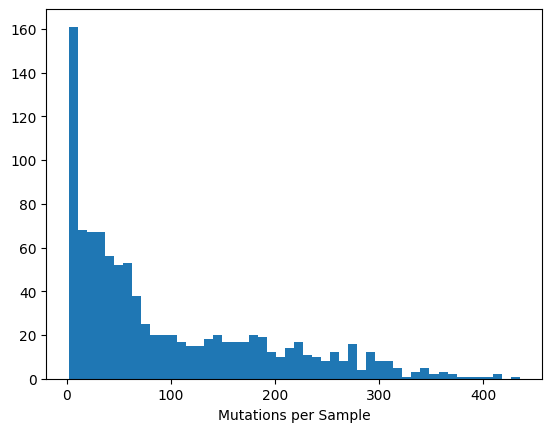

In [15]:
plt.hist(np.unique(instances['sample_idx'], return_counts=True)[1], bins=50)
plt.xlabel('Mutations per Sample')

In [17]:
print(instances['seq_5p'][instances['class'] == 0][:10])

[['C' 'T' 'G' 'C' 'C' 'T']
 ['G' 'A' 'T' 'T' 'T' 'A']
 ['T' 'T' 'T' 'C' 'T' 'T']
 ['G' 'C' 'A' 'G' 'C' 'A']
 ['A' 'T' 'A' 'T' 'A' 'A']
 ['A' 'T' 'C' 'G' 'G' 'G']
 ['G' 'A' 'G' 'T' 'C' 'A']
 ['T' 'T' 'C' 'C' 'A' 'A']
 ['A' 'C' 'A' 'G' 'G' 'T']
 ['C' 'T' 'G' 'C' 'A' 'C']]


In [18]:
print(instances['seq_5p'][instances['class'] == 1][:10])

[['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']
 ['C' 'C' 'G' 'T' 'T' 'A']]


#The negative instances have random sequences 5' of the mutation as expected while the positive instances all have the same sequence.  We need to convert from nucleotide to a format the model can use.

In [19]:

nucleotide_mapping = {'-': 0, 'N': 0, 'A': 1, 'T': 2, 'C': 3, 'G': 4}
instances['seq_5p'] = np.stack(np.apply_along_axis(lambda x: np.array([nucleotide_mapping[i] for i in x]), -1, instances['seq_5p']), axis=0)
instances['seq_3p'] = np.stack(np.apply_along_axis(lambda x: np.array([nucleotide_mapping[i] for i in x]), -1, instances['seq_3p']), axis=0)
instances['seq_ref'] = np.stack(np.apply_along_axis(lambda x: np.array([nucleotide_mapping[i] for i in x]), -1, instances['seq_ref']), axis=0)
instances['seq_alt'] = np.stack(np.apply_along_axis(lambda x: np.array([nucleotide_mapping[i] for i in x]), -1, instances['seq_alt']), axis=0)

#The model will onehot this encoded data on the graph.  We need to stack the reverse of a variant with its forward counterpart to fully represent a variant.

In [20]:

variant_encoding = np.array([0, 2, 1, 4, 3])
instances['seq_5p'] = np.stack([instances['seq_5p'], variant_encoding[instances['seq_3p'][:, ::-1]]], axis=2)
instances['seq_3p'] = np.stack([instances['seq_3p'], variant_encoding[instances['seq_5p'][:, :, 0][:, ::-1]]], axis=2)
t = instances['seq_ref'].copy()
i = t != 0
t[i] = variant_encoding[instances['seq_ref'][:, ::-1]][i[:, ::-1]]
instances['seq_ref'] = np.stack([instances['seq_ref'], t], axis=2)
t = instances['seq_alt'].copy()
i = t != 0
t[i] = variant_encoding[instances['seq_alt'][:, ::-1]][i[:, ::-1]]
instances['seq_alt'] = np.stack([instances['seq_alt'], t], axis=2)
del i, t

#We will onehot the strand ourselves, but it could have been done on graph.

In [23]:
strand_emb_mat = np.concatenate([np.zeros(2)[np.newaxis, :], np.diag(np.ones(2))], axis=0)
instances['strand_emb'] = strand_emb_mat[instances['strand']]

In [24]:
#We need to construct a ragged NumPy array using the sample indexes.  Using sample indexes allows for the possibility that the instances are not in order, for example instance of sample 1, instance of sample 2, instance of sample 1.  If you know that your data is in order then this operation could be done far more efficiently.

In [25]:
indexes = [np.where(instances['sample_idx'] == idx) for idx in range(len(samples['classes']))]
five_p = np.array([instances['seq_5p'][i] for i in indexes], dtype='object')
three_p = np.array([instances['seq_3p'][i] for i in indexes], dtype='object')
ref = np.array([instances['seq_ref'][i] for i in indexes], dtype='object')
alt = np.array([instances['seq_alt'][i] for i in indexes], dtype='object')
strand = np.array([instances['strand_emb'][i] for i in indexes], dtype='object')

#In order to provide the graph ragged tensors we use loaders.  The loaders will automatically infer that ragged tensors need to be made from the fact that the arrays are dtype object.

In [26]:

five_p_loader = DatasetsUtils.Map.FromNumpy(five_p, tf.int32)
three_p_loader = DatasetsUtils.Map.FromNumpy(three_p, tf.int32)
ref_loader = DatasetsUtils.Map.FromNumpy(ref, tf.int32)
alt_loader = DatasetsUtils.Map.FromNumpy(alt, tf.int32)
strand_loader = DatasetsUtils.Map.FromNumpy(strand, tf.float32)

In [ ]:
##A loader is not needed for data which will not be converted into a ragged tensor but can still be used.

In [28]:

y_label = np.array(samples['classes'])[:, np.newaxis]
y_strat = y_label
y_label_loader = DatasetsUtils.Map.FromNumpy(y_label, tf.float32)

In [ ]:

idx_train, idx_test = next(StratifiedShuffleSplit(random_state=0, n_splits=1, test_size=200).split(y_strat, y_strat))
idx_train, idx_valid = [idx_train[idx] for idx in list(StratifiedShuffleSplit(n_splits=1, test_size=300, random_state=0).split(np.zeros_like(y_strat)[idx_train], y_strat[idx_train]))[0]]

ds_train = tf.data.Dataset.from_tensor_slices((idx_train, y_strat[idx_train]))
ds_train = ds_train.apply(DatasetsUtils.Apply.StratifiedMinibatch(batch_size=100, ds_size=len(idx_train)))
ds_train = ds_train.map(lambda x: ((five_p_loader(x),
                                    three_p_loader(x),
                                    ref_loader(x),
                                    alt_loader(x),
                                    strand_loader(x)),
                                    y_label_loader(x)
                                   ))


ds_valid = tf.data.Dataset.from_tensor_slices(((five_p_loader(idx_valid),
                                                three_p_loader(idx_valid),
                                                ref_loader(idx_valid),
                                                alt_loader(idx_valid),
                                                strand_loader(idx_valid),
                                                ),
                                               tf.gather(y_label, idx_valid),
                                               ))
ds_valid = ds_valid.batch(len(idx_valid), drop_remainder=False)

ds_test = tf.data.Dataset.from_tensor_slices(((five_p_loader(idx_test),
                                                three_p_loader(idx_test),
                                                ref_loader(idx_test),
                                                alt_loader(idx_test),
                                                strand_loader(idx_test),
                                                ),
                                               tf.gather(y_label, idx_test),
                                               ))
ds_test = ds_test.batch(len(idx_test), drop_remainder=False)

In [ ]:
#We need to build our sequence encoder.  The sequences are 6 nucleotides long, have an embedding dimension of 4, and have 2 strands.  We will use 16 kernels for the 5' and 3' sequences, and 8 kernels for the ref and alt sequences.

In [30]:
tile_encoder = InstanceModels.VariantSequence(6, 4, 2, [16, 16, 8, 8])

In [ ]:
#We will build our MIL model with the default parameters.

In [31]:
mil = RaggedModels.MIL(instance_encoders=[tile_encoder.model])

In [32]:
losses = [tf.keras.losses.BinaryCrossentropy(from_logits=True)]
mil.model.compile(loss=losses,
                  metrics=['accuracy', tf.keras.metrics.BinaryCrossentropy(from_logits=True)],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                ))
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', min_delta=0.00001, patience=20, mode='min', restore_best_weights=True)]
history = mil.model.fit(ds_train, steps_per_epoch=10, validation_data=ds_valid, epochs=10000, callbacks=callbacks)
evaluation = mil.model.evaluate(ds_test)

Epoch 1/10000


2023-01-03 16:58:19.535310: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


10/10 [==============================] - 11s 206ms/step - loss: 1.5316 - accuracy: 0.4784 - binary_crossentropy: 0.9080 - val_loss: 1.2865 - val_accuracy: 0.4767 - val_binary_crossentropy: 0.6897
Epoch 2/10000
10/10 [==============================] - 1s 131ms/step - loss: 1.2582 - accuracy: 0.4772 - binary_crossentropy: 0.6815 - val_loss: 1.2238 - val_accuracy: 0.4767 - val_binary_crossentropy: 0.6702
Epoch 3/10000
10/10 [==============================] - 1s 127ms/step - loss: 1.2030 - accuracy: 0.4784 - binary_crossentropy: 0.6657 - val_loss: 1.1695 - val_accuracy: 0.4767 - val_binary_crossentropy: 0.6508
Epoch 4/10000
10/10 [==============================] - 1s 150ms/step - loss: 1.1563 - accuracy: 0.4784 - binary_crossentropy: 0.6512 - val_loss: 1.1239 - val_accuracy: 0.4833 - val_binary_crossentropy: 0.6344
Epoch 5/10000
10/10 [==============================] - 1s 129ms/step - loss: 1.1044 - accuracy: 0.5360 - binary_crossentropy: 0.6265 - val_loss: 1.0663 - val_accuracy: 0.5333 - 

In [ ]:
#Check the performance on test data, this model achieved 99% accuracy on this task.

In [33]:
print(evaluation)

[0.11439504474401474, 0.9900000095367432, 0.035059455782175064]


In [ ]:
#To get the attention we call a separate model which was built by default.

In [34]:
attention = mil.attention_model.predict(ds_test).to_list()

In [35]:
len(attention)

200

#The attention is a list per sample.

(array([1.841e+03, 5.902e+03, 2.963e+03, 7.680e+02, 2.280e+02, 1.850e+02,
        1.650e+02, 7.500e+01, 4.500e+01, 1.500e+01, 7.000e+00, 7.000e+00,
        8.000e+00, 6.000e+00, 1.100e+01, 1.400e+01, 1.300e+01, 1.200e+01,
        2.000e+01, 1.000e+01, 2.200e+01, 2.100e+01, 2.200e+01, 1.800e+01,
        2.000e+01, 2.700e+01, 2.600e+01, 3.700e+01, 3.000e+01, 3.100e+01,
        4.100e+01, 4.700e+01, 5.000e+01, 6.500e+01, 4.700e+01, 6.600e+01,
        6.000e+01, 6.700e+01, 7.700e+01, 8.500e+01, 5.700e+01, 9.300e+01,
        8.800e+01, 9.800e+01, 1.170e+02, 1.230e+02, 1.320e+02, 1.600e+02,
        1.480e+02, 1.520e+02, 1.390e+02, 1.400e+02, 1.380e+02, 1.580e+02,
        1.680e+02, 1.640e+02, 1.560e+02, 1.760e+02, 1.460e+02, 1.550e+02,
        1.410e+02, 1.470e+02, 1.530e+02, 1.480e+02, 1.270e+02, 1.290e+02,
        1.380e+02, 1.210e+02, 1.380e+02, 9.800e+01, 1.070e+02, 9.200e+01,
        7.700e+01, 8.500e+01, 6.500e+01, 7.000e+01, 6.200e+01, 6.400e+01,
        6.400e+01, 4.400e+01, 3.900e+0

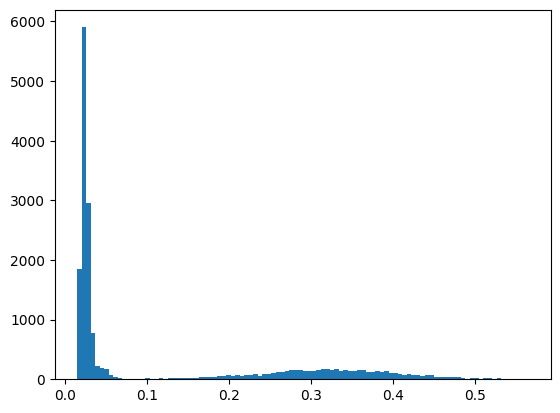

In [37]:
plt.hist(np.concatenate(attention), bins=100)
plt.xlabel('Attention')

In [ ]:
#As we can see most instances received low attention while some received higher attention.